![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# PCA - Tarefa 01: *HAR* com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn import tree
from sklearn.model_selection import train_test_split

filename_features = "../Dados/UCI HAR Dataset/features.txt"
filename_labels = "../Dados/UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "../Dados/UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "../Dados/UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "../Dados/UCI HAR Dataset/train/y_train.txt"

filename_subtest = "../Dados/UCI HAR Dataset/test/subject_test.txt"
ffilename_xtest = "../Dados/UCI HAR Dataset/test/X_test.txt"
filename_ytest = "../Dados/UCI HAR Dataset/test/y_test.txt"

features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
lista_colunas = features['nome_var']
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=lista_colunas)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(ffilename_xtest, delim_whitespace=True, header=None, names=lista_colunas)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

## Árvore de decisão

Rode uma árvore de decisão com todas as variáveis, utilizando o ```ccp_alpha=0.001```. Avalie a acurácia nas bases de treinamento e teste. Avalie o tempo de processamento.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

In [76]:
arvore_01_treino = DecisionTreeClassifier(random_state=2360873, ccp_alpha=0.001)
arvore_01_treino.fit(X_train, y_train)

print(f"Profundidade: {arvore_01_treino.tree_.max_depth}")
print(f"Acurácia na base de treino: {arvore_01_treino.score(X_train, y_train):.2f}")
print(f"MSE na base de treino: {mean_squared_error(y_train, arvore_01_treino.predict(X_train)):.2f}")

Profundidade: 12
Acurácia na base de treino: 0.98
MSE na base de treino: 0.03


In [77]:
arvore_01_test = DecisionTreeClassifier(random_state=2360873, ccp_alpha=0.001)
arvore_01_test.fit(X_test, y_test)

print(f"Profundidade: {arvore_01_test.tree_.max_depth}")
print(f"Acurácia na base de teste: {arvore_01_test.score(X_test, y_test):.2f}")
print(f"MSE na base de teste: {mean_squared_error(y_test, arvore_01_test.predict(X_test)):.2f}")

Profundidade: 12
Acurácia na base de teste: 0.99
MSE na base de teste: 0.01


## Árvore com PCA

Faça uma análise de componemtes principais das variáveis originais. Utilize apenas uma componente. Faça uma árvore de decisão com esta componente como variável explicativa.

- Avalie a acurácia nas bases de treinamento e teste
- Avalie o tempo de processamento

In [78]:
%%time
prcomp = PCA(n_components=561).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

pc_teste.shape

CPU times: total: 1.41 s
Wall time: 272 ms


(1838, 561)

In [79]:
%%time
n=1

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_teste  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

CPU times: total: 0 ns
Wall time: 0 ns


,cp1
0,-5.949774
1,-5.731226
2,5.052964
3,-6.188639
4,3.550978


In [80]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 3.08 s
Wall time: 3.26 s


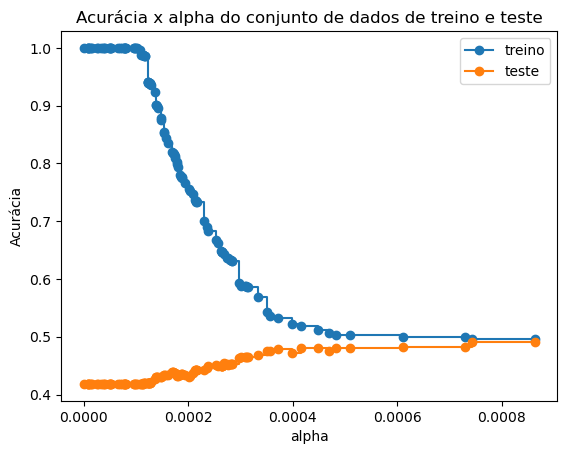

In [81]:
train_scores = [clf.score(pc_train, y_train) for clf in clfs]
test_scores = [clf.score(pc_teste, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], test_scores[:nx], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

In [82]:
ind_melhor_arvore = len(train_scores) - train_scores[::-1].index(max(train_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_teste, y_test)*100:.1f}')

melhor_arvore

Acurácia da melhor árvore na base de treino:    100.0
Acurácia da melhor árvore na base de teste:     41.8


DecisionTreeClassifier(ccp_alpha=0.00010052163869957772, random_state=2360873)

## Testando o número de componentes

Com base no código acima, teste a árvore de classificação com pelo menos as seguintes possibilidades de quantidades de componentes: ```[1, 2, 5, 10, 50]```. Avalie para cada uma delas:

- Acurácia nas bases de treino e teste
- Tempo de processamento


# N_COMPONETS = 2

In [83]:
%%time
prcomp = PCA(n_components=561).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

pc_teste.shape

CPU times: total: 1.39 s
Wall time: 252 ms


(1838, 561)

In [84]:
%%time
n=2

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_teste  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

CPU times: total: 0 ns
Wall time: 0 ns


,cp1,cp2
0,-5.949774,1.173969
1,-5.731226,0.721496
2,5.052964,-2.842348
3,-6.188639,1.578193
4,3.550978,-2.234915


In [85]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 4.39 s
Wall time: 4.47 s


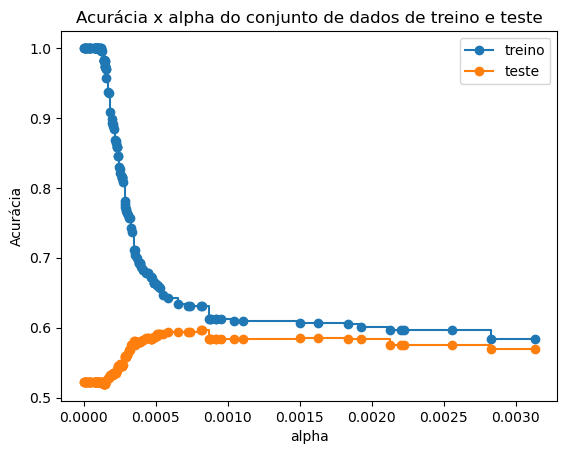

In [86]:
train_scores = [clf.score(pc_train, y_train) for clf in clfs]
test_scores = [clf.score(pc_teste, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], test_scores[:nx], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

In [87]:
ind_melhor_arvore = len(train_scores) - train_scores[::-1].index(max(train_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_teste, y_test)*100:.1f}')

melhor_arvore

Acurácia da melhor árvore na base de treino:    100.0
Acurácia da melhor árvore na base de teste:     52.2


DecisionTreeClassifier(ccp_alpha=0.00011728369918218191, random_state=2360873)

# N_COMPONETS = 5

In [88]:
%%time
prcomp = PCA(n_components=561).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

pc_teste.shape

CPU times: total: 1.77 s
Wall time: 268 ms


(1838, 561)

In [89]:
%%time
n=5

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_teste  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

CPU times: total: 0 ns
Wall time: 388 µs


,cp1,cp2,cp3,cp4,cp5
0,-5.949774,1.173969,-1.886419,0.749519,0.050220
1,-5.731226,0.721496,-2.055212,0.529960,-0.713089
2,5.052964,-2.842348,0.406904,1.444510,0.963683
3,-6.188639,1.578193,2.106647,-0.016444,0.906823
4,3.550978,-2.234915,0.194259,-0.266276,0.957594


In [90]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 4.83 s
Wall time: 5.09 s


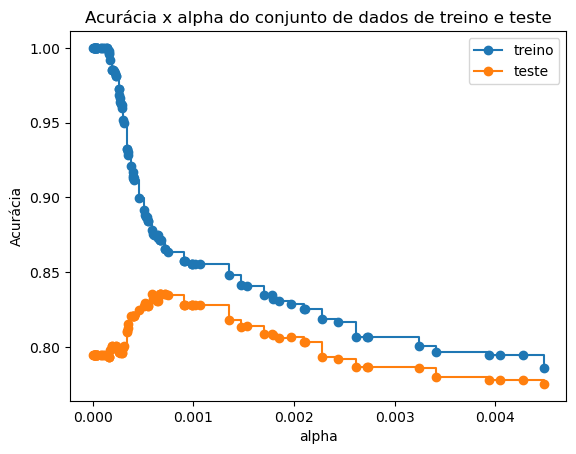

In [91]:
train_scores = [clf.score(pc_train, y_train) for clf in clfs]
test_scores = [clf.score(pc_teste, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], test_scores[:nx], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

In [92]:
ind_melhor_arvore = len(train_scores) - train_scores[::-1].index(max(train_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_teste, y_test)*100:.1f}')

melhor_arvore

Acurácia da melhor árvore na base de treino:    100.0
Acurácia da melhor árvore na base de teste:     79.4


DecisionTreeClassifier(ccp_alpha=0.00013787416710853, random_state=2360873)

# N_COMPONETS = 10

In [102]:
%%time
prcomp = PCA(n_components=561).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

pc_teste.shape

CPU times: total: 1.45 s
Wall time: 252 ms


(1838, 561)

In [103]:
%%time
n=10

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_teste  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

CPU times: total: 0 ns
Wall time: 1.13 ms


,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10
0,-5.949774,1.173969,-1.886419,0.749519,0.050220,-0.086911,-0.831659,0.562181,-0.504805,-0.506014
1,-5.731226,0.721496,-2.055212,0.529960,-0.713089,0.420951,-0.114771,0.809837,-0.073901,-0.146211
2,5.052964,-2.842348,0.406904,1.444510,0.963683,0.258702,-1.802108,0.573104,1.798114,0.804236
3,-6.188639,1.578193,2.106647,-0.016444,0.906823,-0.113340,0.046806,0.602954,-0.796694,1.106710
4,3.550978,-2.234915,0.194259,-0.266276,0.957594,-0.924318,0.196484,0.740680,-0.831974,-0.641331


In [104]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 8.89 s
Wall time: 9.5 s


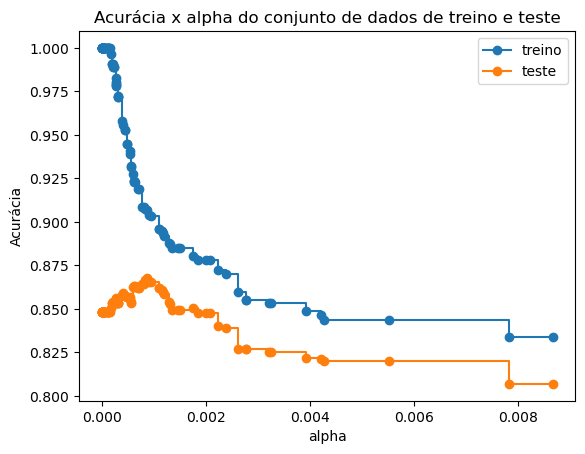

In [105]:
train_scores = [clf.score(pc_train, y_train) for clf in clfs]
test_scores = [clf.score(pc_teste, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], test_scores[:nx], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

In [106]:
ind_melhor_arvore = len(train_scores) - train_scores[::-1].index(max(train_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_teste, y_test)*100:.1f}')

melhor_arvore

Acurácia da melhor árvore na base de treino:    100.0
Acurácia da melhor árvore na base de teste:     84.8


DecisionTreeClassifier(ccp_alpha=0.00015255122138480644, random_state=2360873)

# N_COMPONETS = 50

In [107]:
%%time
prcomp = PCA(n_components=561).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

pc_teste.shape

CPU times: total: 1.28 s
Wall time: 271 ms


(1838, 561)

In [108]:
%%time
n=50

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train = pd.DataFrame(pc_treino[:,:n], columns = colunas)
pc_teste  = pd.DataFrame( pc_teste[:,:n], columns = colunas)

pc_train.head()

CPU times: total: 0 ns
Wall time: 0 ns


,cp1,cp2,cp3,cp4,cp5,cp6,cp7,cp8,cp9,cp10,...,cp41,cp42,cp43,cp44,cp45,cp46,cp47,cp48,cp49,cp50
0,-5.949774,1.173969,-1.886419,0.749519,0.050220,-0.086911,-0.831659,0.562181,-0.504805,-0.506014,...,0.296665,-0.093686,0.030147,0.158222,0.347971,0.285906,-0.013850,0.024223,0.418933,-0.288990
1,-5.731226,0.721496,-2.055212,0.529960,-0.713089,0.420951,-0.114771,0.809837,-0.073901,-0.146211,...,0.108948,-0.126198,-0.080046,0.024051,0.046315,0.177748,-0.054875,-0.194157,0.095703,-0.197173
2,5.052964,-2.842348,0.406904,1.444510,0.963683,0.258702,-1.802108,0.573104,1.798114,0.804236,...,-0.279202,-0.393769,0.632398,-0.328494,0.420094,0.094219,-0.255882,0.220395,0.590117,0.279725
3,-6.188639,1.578193,2.106647,-0.016444,0.906823,-0.113340,0.046806,0.602954,-0.796694,1.106710,...,0.194668,-0.057504,-0.337161,0.293734,0.044259,-0.152348,0.484299,0.136079,0.005185,0.225564
4,3.550978,-2.234915,0.194259,-0.266276,0.957594,-0.924318,0.196484,0.740680,-0.831974,-0.641331,...,0.306864,-0.242996,0.436103,-0.312361,-0.155980,0.014273,0.621077,-0.121715,0.174288,0.069905


In [109]:
%%time
clf = DecisionTreeClassifier(random_state=1234).fit(pc_train, y_train)

caminho = DecisionTreeClassifier(random_state=2360873, min_samples_leaf=20).cost_complexity_pruning_path(pc_train, y_train)
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities

ccp_alphas = np.unique(ccp_alphas[ccp_alphas>=0])

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(pc_train, y_train)
    clfs.append(clf)

CPU times: total: 44.8 s
Wall time: 48.7 s


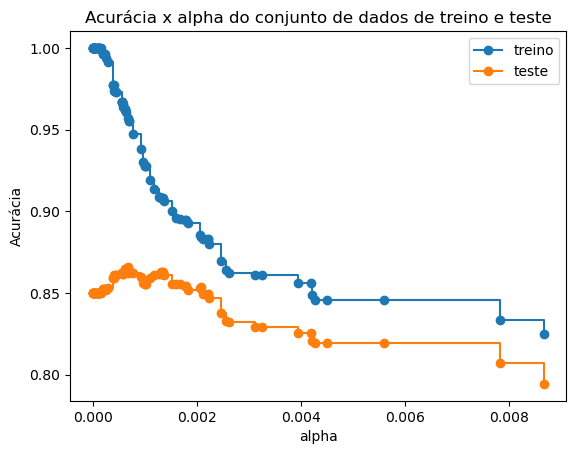

In [110]:
train_scores = [clf.score(pc_train, y_train) for clf in clfs]
test_scores = [clf.score(pc_teste, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Acurácia")
ax.set_title("Acurácia x alpha do conjunto de dados de treino e teste")
nx=-10
ax.plot(ccp_alphas[:nx], train_scores[:nx], marker='o', label="treino",    drawstyle="steps-post")
ax.plot(ccp_alphas[:nx], test_scores[:nx], marker='o', label="teste", drawstyle="steps-post")

ax.legend()
plt.show()

In [111]:
ind_melhor_arvore = len(train_scores) - train_scores[::-1].index(max(train_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de treino:    {train_scores[ind_melhor_arvore]*100:.1f}')
print(f'Acurácia da melhor árvore na base de teste:     {melhor_arvore.score(pc_teste, y_test)*100:.1f}')

melhor_arvore

Acurácia da melhor árvore na base de treino:    100.0
Acurácia da melhor árvore na base de teste:     85.0


DecisionTreeClassifier(ccp_alpha=0.00014984213061239174, random_state=2360873)

## Conclua

- O que aconteceu com a acurácia?
- O que aconteceu com o tempo de processamento?

##### CONFORME O NUMERO DE COMPONENTES FOI AUMENTANDO A ACURÁCIA DO SISTEMA FOI AUMENTANDO NA BASE DE TESTE TAMBÉM. PORÉM, EM DETRIMENTO AO AUMENTO DA ACURÁCIA, O TEMPO DE PROCESSAMENTO AUMENTO TAMBÉM, NECESSITANDO DE MAIS ROBUSTEZ DE HARDWARE PARA ELABORAR ESSA TAREFA.